## Benchmark 1: oneshot naive

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import pandas as pd
import matplotlib

print(f'Python: {sys.version}')
print()
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3


Let's start with an almost totally naive model and see where that gets us. The plan is to fill the submission file with the last known MBD value for each county and upload it.

This will give us a good idea of where we are starting and how our own internal cross validation relates to the score we can expect on the public leader board.

In [2]:
# Load up training file, set dtype for first day of month

training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [3]:
# Load up test datafile, set dtype for first day of month
test_df = pd.read_csv(f'{conf.DATA_PATH}/test.csv')
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [4]:
# Sort each county by timepoint and take the first (most recent) row from each
last_value_df = training_df.sort_values('first_day_of_month', ascending=False).groupby('cfips').first()
last_value_df.reset_index(inplace=True, drop=False)
last_value_df.head()

,cfips,row_id,county,state,first_day_of_month,microbusiness_density,active
0,1001,1001_2022-10-01,Autauga County,Alabama,2022-10-01,3.463856,1472
1,1003,1003_2022-10-01,Baldwin County,Alabama,2022-10-01,8.359798,14320
2,1005,1005_2022-10-01,Barbour County,Alabama,2022-10-01,1.232074,244
3,1007,1007_2022-10-01,Bibb County,Alabama,2022-10-01,1.287240,229
4,1009,1009_2022-10-01,Blount County,Alabama,2022-10-01,1.831783,813


In [5]:
# Join our test dataframe with our last value dataframe on cfips
prediction_df = pd.merge(test_df, last_value_df, how='inner', on='cfips')

# Clean up columns
prediction_df.drop(['row_id_y', 'first_day_of_month_y'], axis = 1, inplace=True)
prediction_df.rename(columns={'row_id_x': 'row_id', 'first_day_of_month_x': 'first_day_of_month'}, inplace=True)

print(f'Num rows: {len(prediction_df)}')
prediction_df.head()

Num rows: 25080


,row_id,cfips,first_day_of_month,county,state,microbusiness_density,active
0,1001_2022-11-01,1001,2022-11-01,Autauga County,Alabama,3.463856,1472
1,1001_2022-12-01,1001,2022-12-01,Autauga County,Alabama,3.463856,1472
2,1001_2023-01-01,1001,2023-01-01,Autauga County,Alabama,3.463856,1472
3,1001_2023-02-01,1001,2023-02-01,Autauga County,Alabama,3.463856,1472
4,1001_2023-03-01,1001,2023-03-01,Autauga County,Alabama,3.463856,1472


Looks good - just for fun, let's plot some of the predictions to see how they look.

In [6]:
def n_by_n_prediction_scatterplot(
    input_data: pd.DataFrame,
    predictions: pd.DataFrame,
    x_variable: str = 'timepoint_num',
    y_variable: str = 'microbusiness_density',
    xlabel: str = 'Timepoint number',
    ylabel: str = 'Microbusiness density',
    cfips_list: list = [],
    rows: int = 1,
    columns: int = 1,
    main_title: str = 'Microbusiness density timeseries',
    fig_width: int = 10,
    fig_height: int = 10,
    set_const_ylims: bool = False
):
    # Set common y-axis limits for all plots if desired
    if set_const_ylims == True:
        
        # Pool all of the y data we are going to plot
        data_pool = []

        for cfips in cfips_list:
            data_pool.extend(input_data[input_data['cfips'] == cfips][y_variable].to_list())
            data_pool.extend(predictions[predictions['cfips'] == cfips][y_variable].to_list())
        
        # Find min and max values from data pool
        ymin = min(data_pool)
        ymax = max(data_pool)

    # Count plots
    plot_num = 0

    # Initialize figure
    fig, ax = plt.subplots(rows, columns, figsize=(fig_width,fig_height))

    # Loop first on rows, then on columns
    for j in range(rows):
        for i in range(columns):

            # Plot if we have not run out of counties
            if plot_num < len(cfips_list):

                # Get input data for this county
                data = input_data[input_data['cfips'] == cfips_list[plot_num]]

                # Assign x and y from variable parameters
                x_input = data[x_variable]
                y_input = data[y_variable]

                # Plot
                ax[j,i].scatter(x_input, y_input) # type: ignore

                # Get prediction data for this county
                data = predictions[predictions['cfips'] == cfips_list[plot_num]]

                # Assign x and y from variable parameters
                x_predicted = data[x_variable]
                y_predicted = data[y_variable]

                # Plot
                ax[j,i].scatter(x_predicted, y_predicted) # type: ignore

                # Set axis labels
                ax[j,i].set_xlabel(xlabel) # type: ignore
                ax[j,i].set_ylabel(ylabel) # type: ignore

                # Set constant y axis limits, if desired
                if set_const_ylims == True:
                    ax[j,i].set_ylim(ymin, ymax) # type: ignore

                # If x axis is date, rotate tick labels and change font size
                if type(x_input.iloc[0]) == pd._libs.tslibs.timestamps.Timestamp: # type: ignore
                    ax[j,i].set_xticks(ax[j,i].get_xticks()) # type: ignore
                    ax[j,i].set_xticklabels(ax[j,i].get_xticklabels(), rotation=45, fontsize=8) # type: ignore

            plot_num += 1

    # Finish up plot
    plt.suptitle(main_title)
    plt.tight_layout()

    return plt

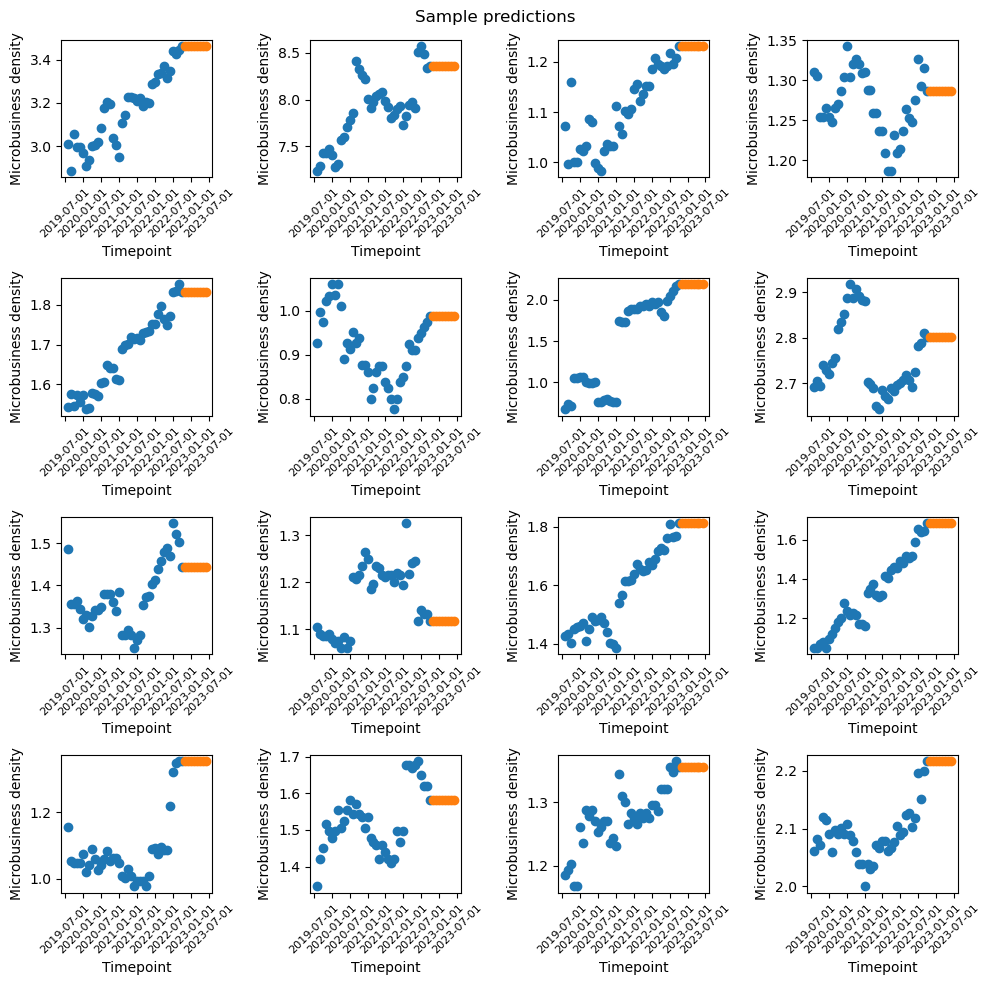

In [7]:
cfips = prediction_df['cfips']
cfips = cfips.drop_duplicates(keep='first').to_list()

plt = n_by_n_prediction_scatterplot(
    input_data = training_df,
    predictions = prediction_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = list(cfips),
    rows = 4,
    columns = 4,
    main_title = 'Sample predictions'
    #set_const_ylims = True
)

plt.show()

Not surprisingly, the predictions look terrible. But two things to keep in mind. First, we only ever have to predict a maximum of 4 timepoints, not 8. Second, we are currently only being scored on the first one, which from this distance doesn't look half bad! Let's submit it and see what happens.

In [8]:
# This is what our submission file should look like
sample_submission_df = pd.read_csv(f'{conf.DATA_PATH}/sample_submission.csv')
print(f'Num rows: {len(sample_submission_df)}')
sample_submission_df.head()

Num rows: 25080


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


In [9]:
# Drop un-needed rows from our prediction so the format matches the sample submission
prediction_df.drop(['cfips', 'first_day_of_month', 'county', 'state', 'active'], axis = 1, inplace=True)
print(f'Num rows: {len(prediction_df)}')
prediction_df.head()

Num rows: 25080


,row_id,microbusiness_density
0,1001_2022-11-01,3.463856
1,1001_2022-12-01,3.463856
2,1001_2023-01-01,3.463856
3,1001_2023-02-01,3.463856
4,1001_2023-03-01,3.463856


In [10]:
# Write csv
output_file = f'{conf.DATA_PATH}/2023-01-31_oneshot_naive_model_submission.csv'
prediction_df.to_csv(output_file, sep=',', index=False)

**Result**: Submitted to Kaggle 2023-01-31 public leaderboard score 1.0936, placed 1332 of 2029. Not bad for what would have been about 20 minutes of work if we had skipped all of the data exploration!